# MPS using the deesse wrapper - basics

## Main points addressed:
- launching deesse
- simple deesse simulations of a categorical variable, with hard data points
- basic statistics on the results
- deesse simulation using pyramids (multi-resolution)
- usage of function for plotting 2D and 3D images

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

# import from package 'geone'
from geone import img
import geone.imgplot as imgplt
import geone.customcolors as ccol
import geone.deesseinterface as dsi

### Remark
The matplotlib figures can be visualized in *interactive* mode:
- `%matplotlib notebook`: enable interactive mode
- `%matplotlib inline`: disable interactive mode

## Training image (TI)

The file `ti.gslib` has the following format:
```    
    Nx Ny Nz [Sx Sy Sz [Ox Oy Oz]]
    nvar
    name_of_variable_1
    ...
    name_of_variable_nvar
    Z1(0)    ... Znvar(0)
    ...
    Z1(Ng-1) ... Znvar(Ng-1)
```
The file is read using the function `img.readImageGslib`, which returns an *image* (class `img.Img`).

In [2]:
ti = img.readImageGslib('ti.gslib')

Note that a variable can contain missing values. Such value is coded with `np.nan`. In the file, one can write for missing values the string `nan` or write the number passed by the (optional) parameter `missing_value` to the function `img.readImageGslib`. (The specific value used by the deesse library is `MPDS_MISSING_VALUE` from the module `geone.deesse_core.deesse`.) The file is then read for example as follows:  

`ti = img.readImageGslib('ti.gslib', missing_value=-9999999)`

## Plot the image using the function `imgplt.drawImage2D`

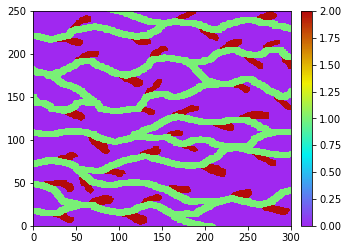

In [3]:
plt.figure(figsize=(5,5))
imgplt.drawImage2D(ti)
plt.show()

One can customize the output using options. For example, one can specify that it is a categorical image and specify the color used for each category.

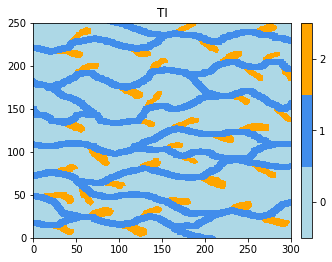

In [4]:
col = ['lightblue', [x/255. for x in ( 65, 141, 235)], 'orange']

plt.figure(figsize=(5,5))
imgplt.drawImage2D(ti, categ=True, categCol=col, title='TI')
plt.show()

## Hard data (point set)

The file `hd.gslib` has the following format:
```    
    npoint
    nvar+3
    name_for_x_coordinate
    name_for_y_coordinate
    name_for_z_coordinate
    name_of_variable_1
    ...
    name_of_variable_nvar
    x(1)      y(1)      z(1)      Z1(1)      ... Znvar(1)
    ...
    x(npoint) y(npoint) z(npoint) Z1(npoint) ... Znvar(npoint)
```
The file is read using the function `img.readPointSetGslib`, which returns a *point set* (class `img.PointSet`).

In [5]:
hd = img.readPointSetGslib('hd.gslib')
hd.varname

['x', 'y', 'z', 'code']

## Input structure for deesse (class `dsi.DeesseInput`)
The variable name for the hard data (in `hd.varname`) and for the simulated variable (parameter `varname` below) should be the same, otherwise, the hard data will be ignored. Moreover, the hard data locations should be in the simulation grid, which is described by its dimensions (number of cells) in each direction, the cell unit in each direction, and the origin (the *corner* of the grid cell with the minimal x, y, z coordinates). Hard data points out of the simulation grid are ignored.  

The hard data can be passed to deesse through a *point set*, i.e. a class `img.PointSet` (parameter `dataPointSet`, as below) or through an *image*, i.e. a class `img.Img` (parameter `dataImage`, not illustrated here), and can contain missing (uninformed) data, using the value `np.nan` or `MPDS_MISSING_VALUE` (not illustrated here).

The type of distance for computing the dissimilarity between patterns is controlled by the parameter `distanceType`: 
- `0` or `'categorical'`: proportion of non-matching nodes (default)
- `1` or `'continuous'`: $L_1$ distance
- `2`: $L_2$ distance
- `3`: $L_p$ distance (requires real positive parameter p given in parameter `powerLpDistance`)
- `4` :$L_\infty$ distance

In [6]:
nreal = 20
deesse_input = dsi.DeesseInput(
    nx=100, ny=100, nz=1,       # dimension of the simulation grid (number of cells)
    sx=1.0, sy=1.0, sz=1.0,     # cells units in the simulation grid (here are the default values)
    ox=0.0, oy=0.0, oz=0.0,     # origin of the simulation grid (here are the default values)
    nv=1, varname='code',       # number of variable(s), name of the variable(s)
    nTI=1, TI=ti,               # number of TI(s), TI (class dsi.Img)
    dataPointSet=hd,            # hard data (optional)
    distanceType='categorical', # distance type: proportion of mismatching nodes (categorical var., default)
    nneighboringNode=24,        # max. number of neighbors (for the patterns)
    distanceThreshold=0.05,     # acceptation threshold (for distance between patterns)
    maxScanFraction=0.25,       # max. scanned fraction of the TI (for simulation of each cell)
    npostProcessingPathMax=1,   # number of post-processing path(s)
    seed=444,                   # seed (initialization of the random number generator)
    nrealization=nreal)         # number of realization(s)

## Launching deesse

### Launch deesse using the function `dsi.deesseRun`
The function `dsi.deesseRun` launches deesse. The code runs in parallel (based on *OpenMP*). The number of threads used can be specified by the optional parameter `nthreads`. Specifying for this parameter a number `-n`, negative or zero, means that the total number of cpus of the system (retrieved by `os.cpu_count()`) except `n` (but at least one) will be used. By default: `nthreads=-1`.

In [7]:
t1 = time.time() # start time
deesse_output = dsi.deesseRun(deesse_input, nthreads=8)
t2 = time.time() # end timec
print('Elapsed time: {:.2g} sec'.format(t2-t1))

Deesse running... [VERSION 3.2 / BUILD NUMBER 20210112 / OpenMP 8 thread(s)]
Deesse run complete
Elapsed time: 3.8 sec


## Retrieve the results (and display)
The function `dsi.deesseRun` returns the dictionary

`deesse_output = {'sim':sim, 'path':path, 'error':error, tiGridNode':tiGridNode, 'tiIndex':tiIndex, 'nwarning':nwarning, 'warnings':warnings}`

The realizations are stored in `deesse_output['sim']`, a 1-dimensional array of *images* (class `img.Img`) of size `deesse_input.nrealization`, `deesse_output['sim'][i]` being the i-th realization.

The total number of warning(s) encountered during the simulation are stored in `deesse_output['nwarning']` (*int*), and all the distincts warning messages are stored in `deesse_output['warnings']` (it's list, possibly empty).

Moreover, additional information can be retrieved in output: the simulation path map (index in the simulation path), the error map (error for the retained candidate), the TI grid node index map (index of the grid node of the retained candidate in the TI) and the TI index map (index of the TI used (makes sense if number of TIs, *deesse_input.nTI*, is greater than 1)). These maps are images with the simulation grid as grid (support), and can be retrieved in output in `deesse_output['path']`, `deesse_output['error']`, `deesse_output['tiGridNode']` and `deesse_output['tiIndex']` respectively. However, these ouputs are set to `None` by default. (A further example illustrates that.)

In [8]:
# Total number of warning(s), and warning messages
deesse_output['nwarning'], deesse_output['warnings']

(0, [])

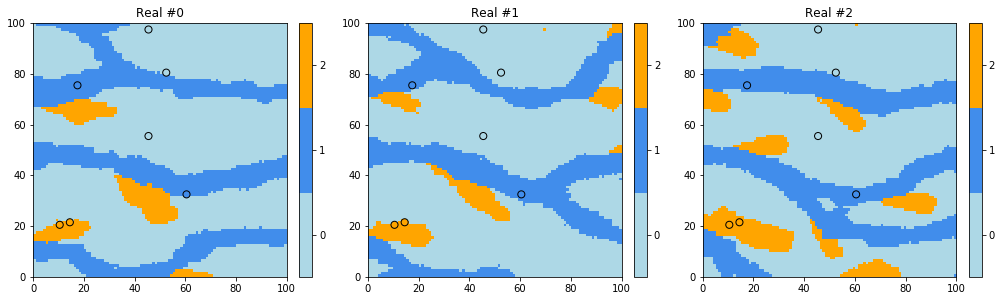

In [9]:
# Retrieve the realizations
sim = deesse_output['sim']

# Display
import matplotlib.colors
hd_col=[matplotlib.colors.to_rgba(col[int(v)]) for v in hd.val[3]] # colors (converted to 'rgba') 
                                                                   # of hard data points

plt.subplots(1, 3, figsize=(17,5)) # 1 x 3 sub-plots
for i in range(3):
    plt.subplot(1, 3, i+1) # select next sub-plot
    imgplt.drawImage2D(sim[i], categ=True, categCol=col, title='Real #{}'.format(i)) # plot real #i
    plt.scatter(hd.x(), hd.y(), marker='o', s=50, 
                color=hd_col, edgecolors='black', linewidths=1) # add hard data points
plt.show()

## Do some statistics on the realizations
The function `img.imageCategProp(im, categ)` allows to compute the pixel-wise proportions of given categories in the list `categ` over all the variables of the image `im`. Hence, we first define an image with `nreal` variables, each one corresponding to one realization, using the function `img.gatherImages`.

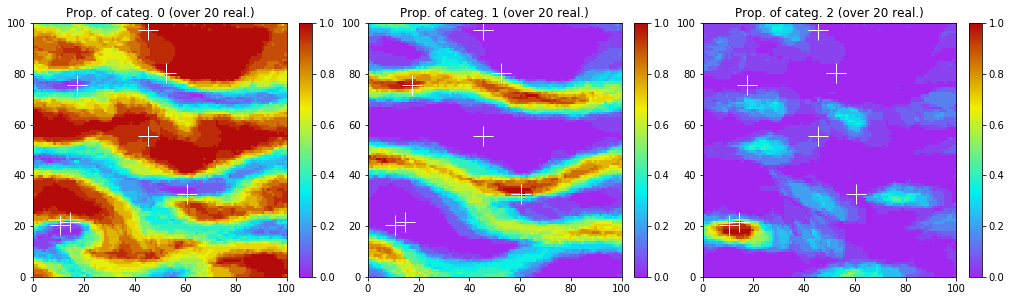

In [10]:
# Gather the nreal realizations into one image
all_sim = img.gatherImages(sim) # all_sim is one image with nreal variables

# Do statistics over all the realizations: compute the pixel-wise proportion for the given categories
all_sim_stats = img.imageCategProp(all_sim, [0, 1, 2])

# Display
plt.subplots(1, 3, figsize=(17,5)) # 1 x 3 sub-plots
for i in range(3):
    plt.subplot(1, 3, i+1) # select next sub-plot
    imgplt.drawImage2D(all_sim_stats, iv=i, 
                       title='Prop. of categ. {} (over {} real.)'.format(i, nreal))
    plt.plot(hd.x(), hd.y(), '+', markersize=20, c='white') # add hard data points
plt.show()

## Simulations using pyramids
Enabling pyramids implies multi-resolution simulations, which can help to better reproduce the spatial structures. It consists in considering lower resolutions of the TI and the simulation grid.  

### Parameters for pyramids (class `dsi.PyramidGeneralParameters` and class `dsi.PyramidParameters`)
Using pyramids requires to define:
- General parameters (class `dsi.PyramidGeneralParameters`):
    - the number of pyramid levels (`npyramidLevel`) additional to the original simulation grid
    - the reduction factors along each axis direction (`kx`, `ky`, `kz`, list of length `npyramidLevel`): the integers `kx[i]`, `ky[i]`, `kz[i]` are these factors between the level `i` and the level `i+1` (the number of cells in each direction are respectively divided by these factors), the simulation grid being the level `0`, and the lowest resolution being the level `npyramidLevel`. (A factor set to zero means that no reduction is made along the corresponding direction.)
- Parameters for each variable (one variable in this example (univariate simulation)):
    - the number of levels (`nlevel`, should be equal to `npyramidLevel` above)
    - the type of pyramid (`pyramidType`), which depends on the type of the variable
    
Note: in the example below, the pyramid type is set to `categorical_auto`: one pyramid for the indicator variable of each category except one is built and used. 

In [11]:
pyrGenParams = dsi.PyramidGeneralParameters(
    npyramidLevel=2,                 # number of pyramid levels, additional to the simulation grid
    kx=[2, 2], ky=[2, 2], kz=[0, 0]  # reduction factors from one level to the next one
                                     #    (kz=[0, 0]: do not apply reduction along z axis)
)

pyrParams = dsi.PyramidParameters(
    nlevel=2,                      # number of levels
    pyramidType='categorical_auto' # type of pyramid (accordingly to categorical variable in this example)
)

### Fill the input structure for deesse and launch deesse

In [12]:
deesse_input = dsi.DeesseInput(
    nx=100, ny=100, nz=1,
    nv=1, varname='code',
    nTI=1, TI=ti,
    dataPointSet=hd,
    distanceType='categorical',
    nneighboringNode=24,
    distanceThreshold=0.05,
    maxScanFraction=0.25,
    pyramidGeneralParameters=pyrGenParams, # set pyramid general parameters
    pyramidParameters=pyrParams,           # set pyramid parameters for each variable
    npostProcessingPathMax=1,
    seed=444,
    nrealization=nreal)

# Run deesse 
deesse_output = dsi.deesseRun(deesse_input)

Deesse running... [VERSION 3.2 / BUILD NUMBER 20210112 / OpenMP 7 thread(s)]
Deesse run complete


### Results

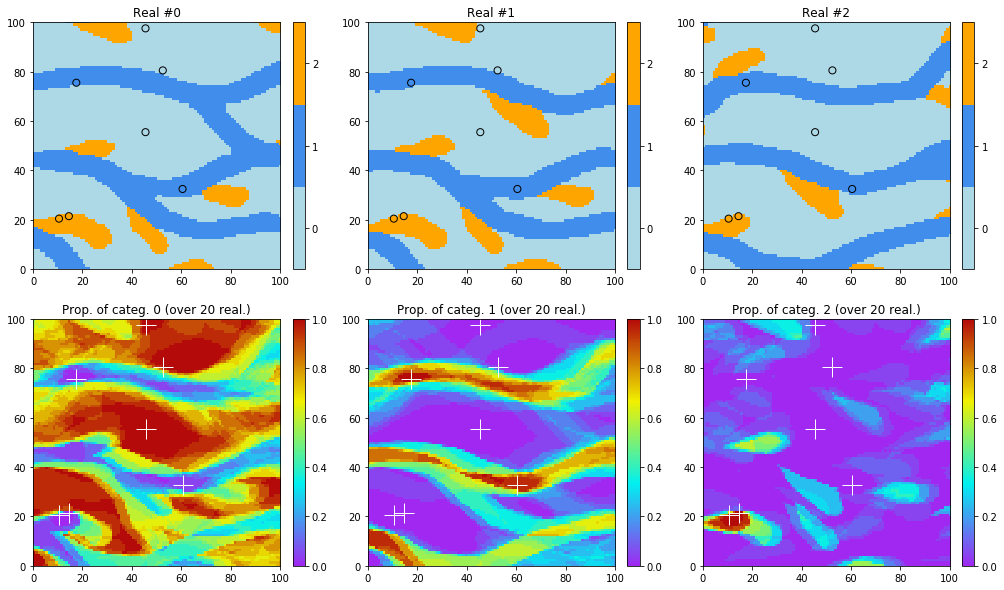

In [13]:
# Retrieve the realizations
sim = deesse_output['sim']

# Gather the nreal realizations into one image
all_sim = img.gatherImages(sim) # all_sim is one image with nreal variables

# Do statistics over all the realizations: compute the pixel-wise proportion for the given categories
all_sim_stats = img.imageCategProp(all_sim, [0, 1, 2])

# Display
plt.subplots(2, 3, figsize=(17,10)) # 2 x 3 sub-plots
for i in range(3):
    plt.subplot(2, 3, i+1) # select next sub-plot
    imgplt.drawImage2D(sim[i], categ=True, categCol=col, title='Real #{}'.format(i)) # plot real #i
    plt.scatter(hd.x(), hd.y(), marker='o', s=50, 
                color=hd_col, edgecolors='black', linewidths=1) # add hard data points
for i in range(3):
    plt.subplot(2, 3, i+4) # select next sub-plot
    imgplt.drawImage2D(all_sim_stats, iv=i, title='Prop. of categ. {} (over {} real.)'.format(i, nreal))
    plt.plot(hd.x(), hd.y(), '+', c='white', markersize=20) # add hard data points
plt.show()

## Simulations using pyramids (2)
Here the pyramid type is set to `categorical_to_continuous`: the pyramid is built for one continuous variable derived from the categorical variable (accounting for the connections between adjacent nodes).

In [14]:
# Deesse input
pyrParams = dsi.PyramidParameters(
    nlevel=2,
    pyramidType='categorical_to_continuous' # type of pyramid (accordingly to categ. variable in this example)
)

deesse_input = dsi.DeesseInput(
    nx=100, ny=100, nz=1,
    nv=1, varname='code',
    nTI=1, TI=ti,
    dataPointSet=hd,
    distanceType='categorical',
    nneighboringNode=24,
    distanceThreshold=0.05,
    maxScanFraction=0.25,
    pyramidGeneralParameters=pyrGenParams,
    pyramidParameters=pyrParams,
    npostProcessingPathMax=1,
    seed=444,
    nrealization=nreal)

# Run deesse 
deesse_output = dsi.deesseRun(deesse_input)

Deesse running... [VERSION 3.2 / BUILD NUMBER 20210112 / OpenMP 7 thread(s)]
Deesse run complete


### Results

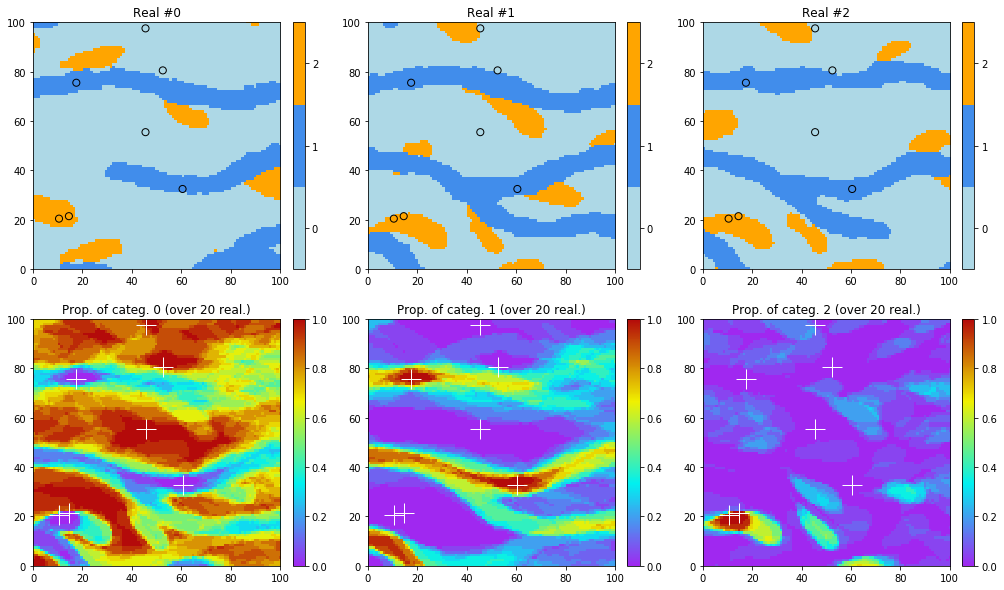

In [15]:
# Retrieve the realizations
sim = deesse_output['sim']

# Gather the nreal realizations into one image
all_sim = img.gatherImages(sim) # all_sim is one image with nreal variables

# Do statistics over all the realizations: compute the pixel-wise proportion for the given categories
all_sim_stats = img.imageCategProp(all_sim, [0, 1, 2])

# Display
plt.subplots(2, 3, figsize=(17,10)) # 2 x 3 sub-plots
for i in range(3):
    plt.subplot(2, 3, i+1) # select next sub-plot
    imgplt.drawImage2D(sim[i], categ=True, categCol=col, title='Real #{}'.format(i)) # plot real #i
    plt.scatter(hd.x(), hd.y(), marker='o', s=50, 
                color=hd_col, edgecolors='black', linewidths=1) # add hard data points
for i in range(3):
    plt.subplot(2, 3, i+4) # select next sub-plot
    imgplt.drawImage2D(all_sim_stats, iv=i, title='Prop. of categ. {} (over {} real.)'.format(i, nreal))
    plt.plot(hd.x(), hd.y(), '+', c='white', markersize=20) # add hard data points
plt.show()

## 3D example

Same principles. For plotting in 3D, one can use the module `geone.imgplot3d`, based on the package `pyvista`.

In [16]:
import geone.imgplot3d as imgplt3

### Read the 3D TI

In [17]:
ti3d = img.readImageGslib('ti_3d.gslib')

### 3D plots 
The following functions can be used:
- `imgplt3.drawImage3D_volume`: 3D plot of *volumes* (smooth interpolation on the vertex of the cells)
- `imgplt3.drawImage3D_surface`: 3D plot of *surfaces* (values at cells are plotted)
- `imgplt3.drawImage3D_slice`: 3D plot of *slices* (planes)

### Remark
The figure are generated with the package `pyvista`. In a notebook, the *plotter* is automatically set in *off screen* (non-interactive) mode. However, in *standard* python environment, the figures are interactive.

To force a pop-up window with an interactive figure in a notebook see the second cell below.

The camera position `cpos` can be specified, it consists of a list of three 3-tuples (`None` for default), `cpos = [camera_location, focus_point, viewup_vector]`, with
- `camera_location`: (tuple of length 3) camera location ("eye")
- `focus_point`    : (tuple of length 3) focus point
- `viewup_vector`  : (tuple of length 3) viewup vector (vector attached to the "head" and pointed to the "sky"), in principle: *(focus_point - camera_location)* is orthogonal to *viewup_vector*

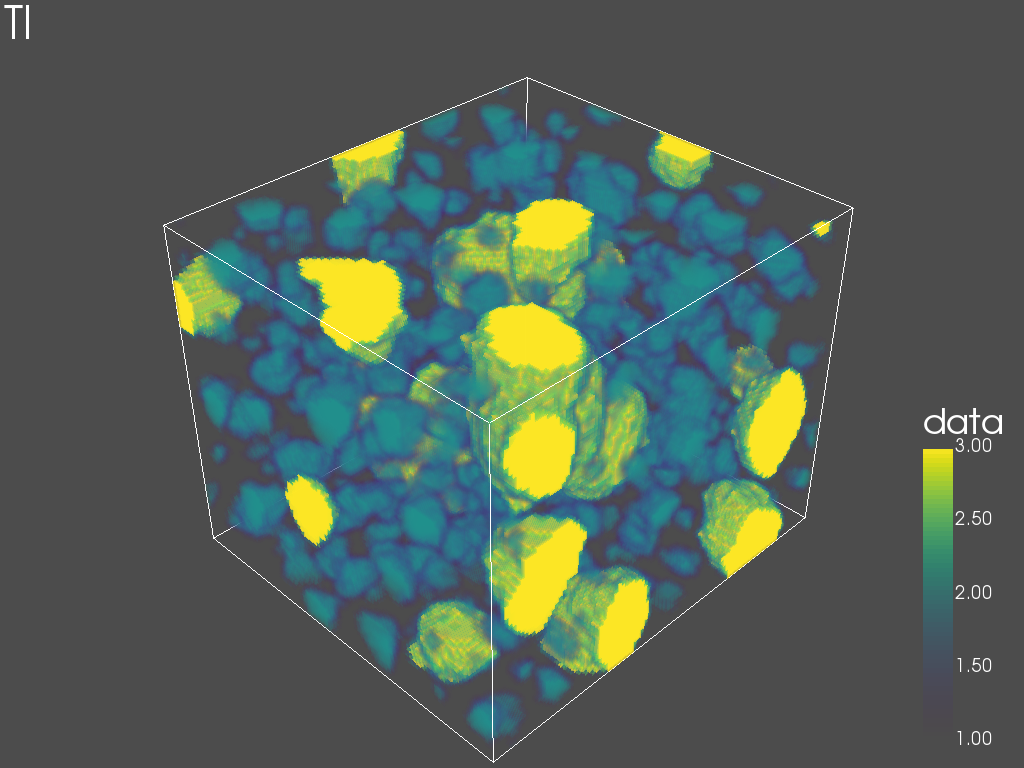

In [18]:
# figure in off screen (non-interactive) mode
imgplt3.drawImage3D_volume(ti3d, scalar_bar_kwargs={'vertical':True}, text='TI')

In [19]:
# Forcing a pop-up window with interactive figure
import pyvista as pv 
pp = pv.Plotter(notebook=False) # open a plotter and specifying 'notebook=False'
imgplt3.drawImage3D_volume(ti3d, plotter=pp,scalar_bar_kwargs={'vertical':True}, text='TI')
pp.show() # show the figure [keyword argument: 'cpos']
# After closing the pop-up window, the position of the camera is retrieved in output.

[(230.60321715465918, 228.51958715112215, 200.19316414615867),
 (50.5, 45.5, 40.5),
 (-0.37327796823136583, -0.37360660486520464, 0.8491652743925405)]

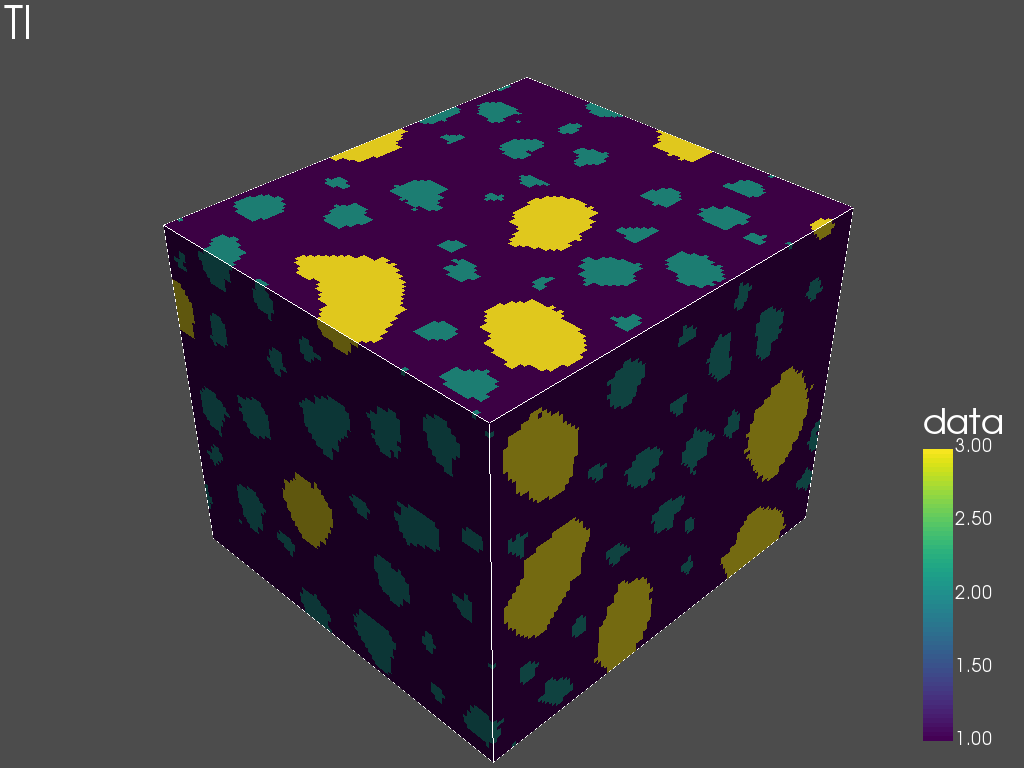

In [20]:
imgplt3.drawImage3D_surface(ti3d, text='TI', scalar_bar_kwargs={'vertical':True})

In [21]:
facies = ti3d.get_unique()
facies

[1.0, 2.0, 3.0]

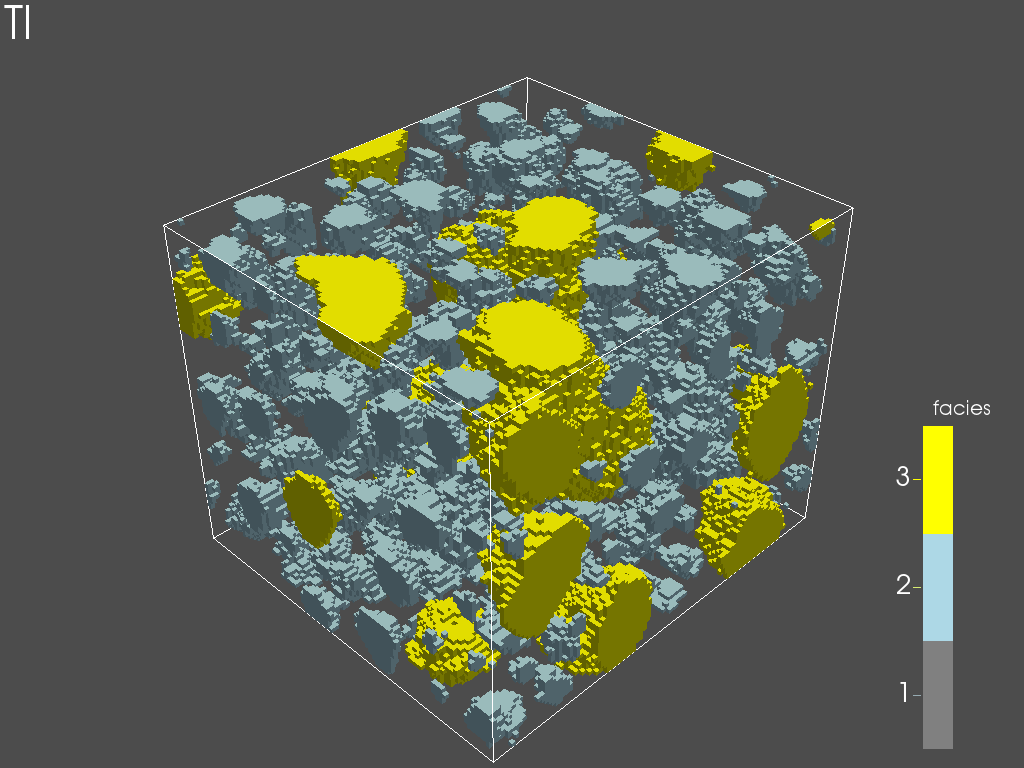

In [22]:
# Customization of the output: 
#    - filter out the plotted values
#    - use (automatic) custom scalar (color) bar for categories with given colors
#    - set title for the scalar bar
colors = ['gray', 'lightblue', 'yellow'] # colors for each category /facies
imgplt3.drawImage3D_surface(ti3d, filtering_value=[2,3], 
                            custom_scalar_bar_for_equidistant_categories=True, 
                            custom_colors=colors,
                            scalar_bar_kwargs={'title':'facies','title_font_size':20, 'vertical':True},
                            text='TI')

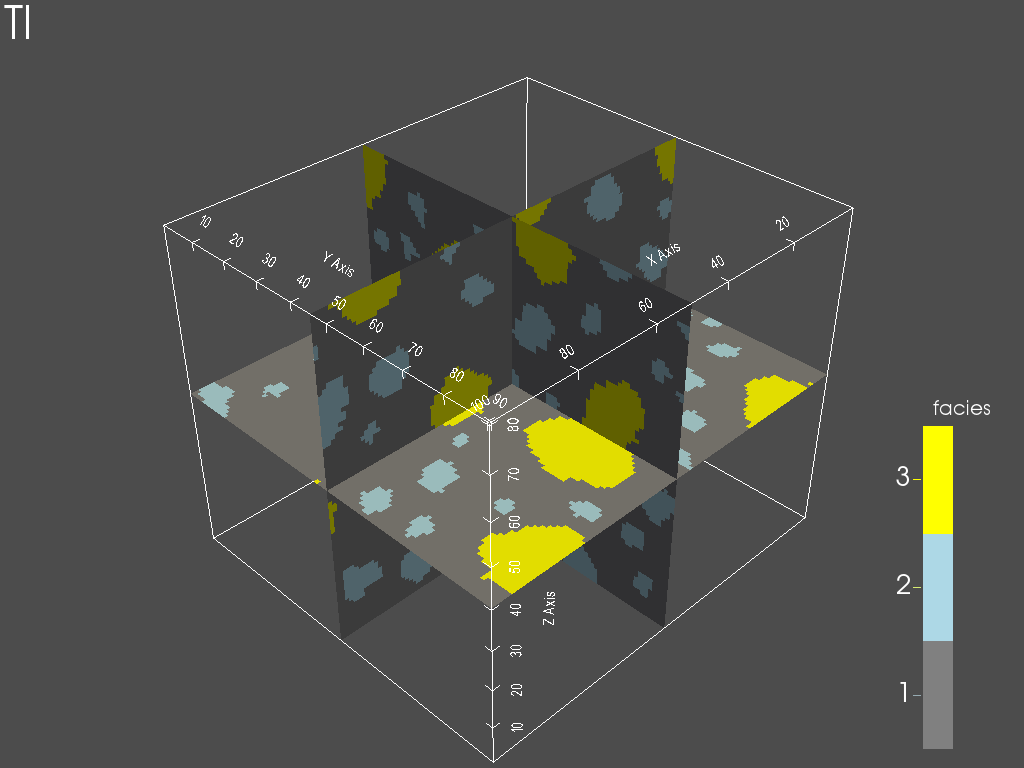

In [23]:
# Slices orthogonal to the axes, going through the center of the images
cx = ti3d.ox + 0.5 * ti3d.nx * ti3d.sx # center along x
cy = ti3d.oy + 0.5 * ti3d.ny * ti3d.sy # center along y
cz = ti3d.oz + 0.5 * ti3d.nz * ti3d.sz # center along z

imgplt3.drawImage3D_slice(ti3d, slice_normal_x=cx, slice_normal_y=cy, slice_normal_z=cz,
                          custom_scalar_bar_for_equidistant_categories=True, 
                          custom_colors=colors,
                          show_bounds=True,   # add bounds (axis with graduation)
                          scalar_bar_kwargs={'title':'facies','title_font_size':20, 'vertical':True},
                          text='TI')

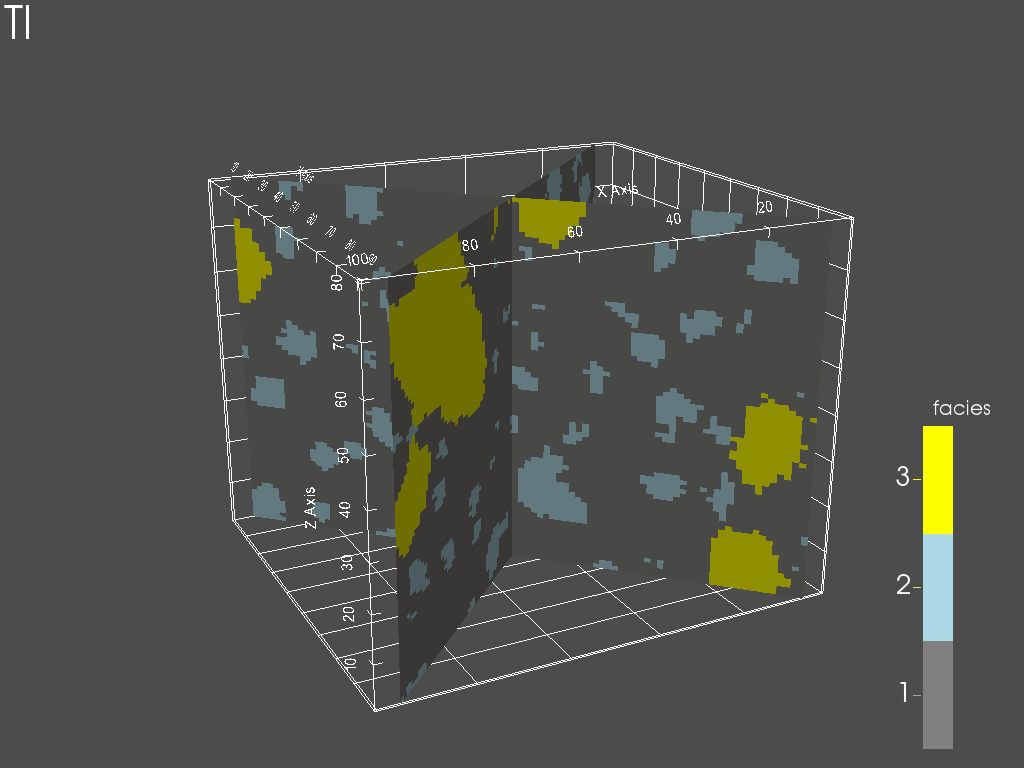

In [24]:
# "Custom" slice defined by the normal vector and a point of the plane
imgplt3.drawImage3D_slice(ti3d, slice_normal_custom=[[(1, 1, 0), (cx, cy, cz)], [(1, -1, 0), (cx, cy, cz)]],
                          custom_scalar_bar_for_equidistant_categories=True, 
                          custom_colors=colors,
                          show_bounds=True, bounds_kwargs={'grid':True}, # add bounds with grid
                          scalar_bar_kwargs={'title':'facies','title_font_size':20, 'vertical':True},
                          text='TI',
                          cpos = (1, 2, 0.8) # set the position of the camera
                         )

### Do a simulation with deesse (3D, unconditional, with pyramids)

In [25]:
# Set input for deesse
pyrGenParams = dsi.PyramidGeneralParameters(
    npyramidLevel=2,
    kx=[2, 2], ky=[2, 2], kz=[2, 2]
)

pyrParams = dsi.PyramidParameters(
    nlevel=2,
    pyramidType='categorical_auto'
)

nreal = 1

deesse_input = dsi.DeesseInput(
    nx=60, ny=60, nz=60,
    nv=1, varname='code',
    nTI=1, TI=ti3d,
    nneighboringNode=24,
    distanceThreshold=0.05,
    maxScanFraction=0.25,
    pyramidGeneralParameters=pyrGenParams,
    pyramidParameters=pyrParams,
    npostProcessingPathMax=1,
    seed=444,
    nrealization=nreal)

# Run deesse 
deesse_output = dsi.deesseRun(deesse_input)

Deesse running... [VERSION 3.2 / BUILD NUMBER 20210112 / OpenMP 7 thread(s)]
Deesse run complete


### Plot the results

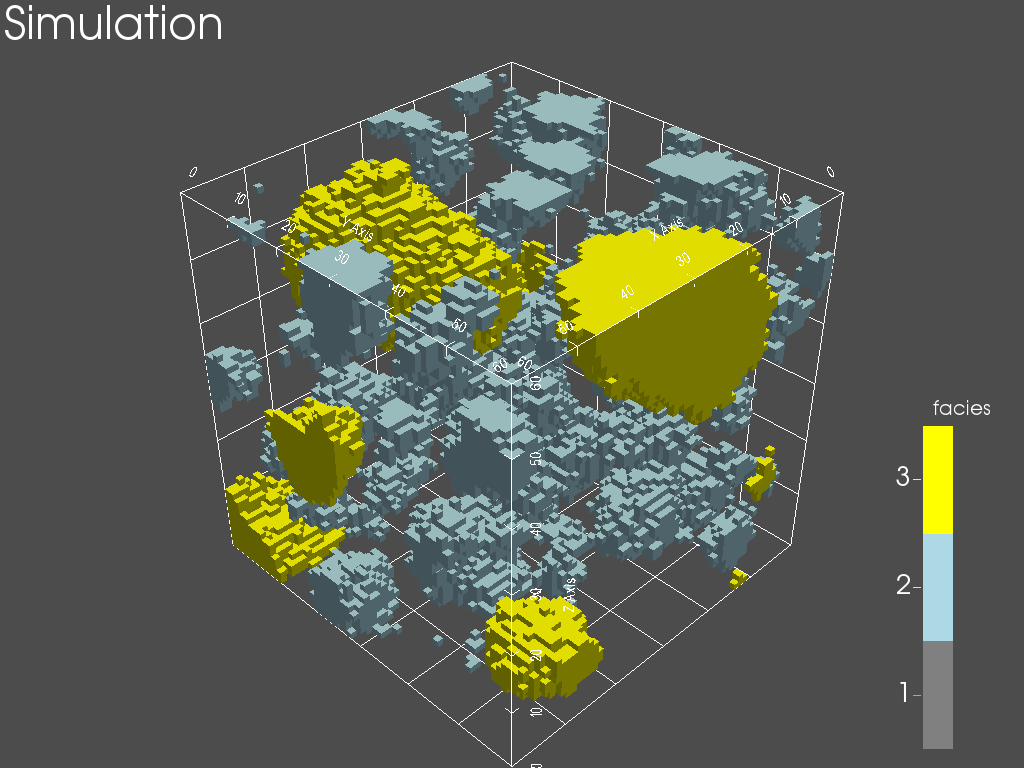

In [26]:
# Retrieve the realization
sim = deesse_output['sim']

# Plot
imgplt3.drawImage3D_surface(sim[0], filtering_value=[2,3], 
                            custom_scalar_bar_for_equidistant_categories=True, 
                            custom_colors=colors,
                            show_bounds=True, bounds_kwargs={'grid':True},
                            scalar_bar_kwargs={'title':'facies','title_font_size':20, 'vertical':True},
                            text='Simulation')